Moving average crossover
https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp

Trading rules:
1. Buy when price crosses above MA and sell when it crosses below

In [7]:
#import libraries
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [8]:
#define variables
STARTING_BALANCE = 10000

In [9]:
#define time period
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2021, 1, 1)
DAYS = END - START
YEARS = DAYS.days / 365.25

In [10]:
#load data into a pandas dataframe
price = pdr.get_data_yahoo('^GSPC', START, END)

price.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971


In [11]:
#drop last two columns as they are not needed
price = price.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], 1)

price.head()

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


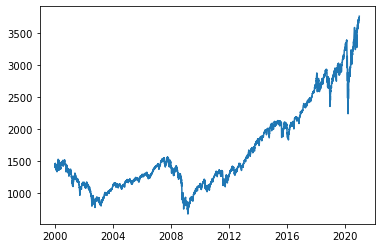

In [12]:
#plot chart
plt.plot(price.Close)
plt.show()

In [13]:
#calculate daily return
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price

,Close,Return,Bench_Bal
Date,,,
2000-01-03,1455.219971,1.000000,10000.000000
2000-01-04,1399.420044,0.961655,9616.553319
2000-01-05,1402.109985,1.001922,9635.038094
2000-01-06,1403.449951,1.000956,9644.246089
2000-01-07,1441.469971,1.027090,9905.512567
...,...,...,...
2020-12-24,3703.060059,1.003537,25446.737491
2020-12-28,3735.360107,1.008723,25668.697397
2020-12-29,3727.040039,0.997773,25611.523440


In [14]:
def backtest(price, period):
    #calculate moving average
    price['SMA'] = price.Close.rolling(window = period).mean()
    
    #Hold a position for every day the close is above the MA
    price['Long'] = price.Close > price.SMA
    
    #calculate the daily return from Open to Close on days in the market
    #on days when there is no trade, return is 1
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    
    #calculate balance
    price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()
    
    #calculate drawdown
    price['Sys_Peak'] = price['Sys_Bal'].cummax()

    price['Sys_DD'] = price['Sys_Peak'] - price['Sys_Bal']
    
    cagr_sys = (((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100
    dd_sys = round(((price.Sys_DD / price.Sys_Peak).max()) * -100, 2)
    mar_sys = cagr_sys / abs(dd_sys)
    
    
    return cagr_sys, dd_sys, mar_sys

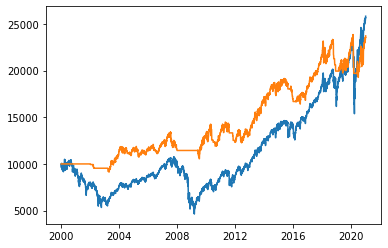

In [15]:
#backtest the optimal value
backtest(price, 200)

#plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal)

plt.show()

In [16]:
periods = []
periods.extend(range(10, 250, 1))
cagr = []
dd = []
mar = []

for period in periods:
    cagr_sys, dd_sys, mar_sys = backtest(price, period)
    cagr.append(cagr_sys)
    dd.append(dd_sys)
    mar.append(mar_sys)

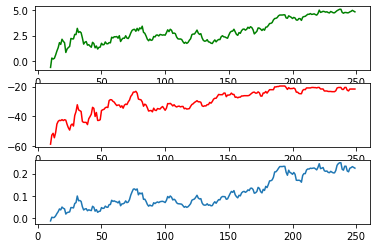

In [17]:
plt.figure()

#create subplot for price data
plt.subplot(311)
plt.plot(periods, cagr, 'g')

#create subplot for MACD
plt.subplot(312)
plt.plot(periods, dd, 'r')

#create subplot for MAR
plt.subplot(313)
plt.plot(periods, mar)

#show plot
plt.show()

In [18]:
optimal_value = periods[mar.index(max(mar))]

optimal_value

237

In [19]:
#backtest the optimal value
backtest(price, optimal_value)

(5.1109812880114625, -20.57, 0.24846773398208374)

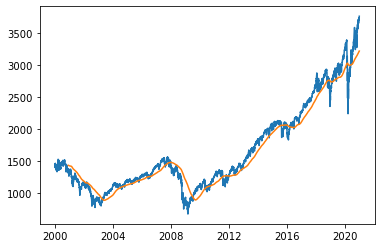

In [20]:
plt.plot(price.Close)
plt.plot(price.SMA)

plt.show()

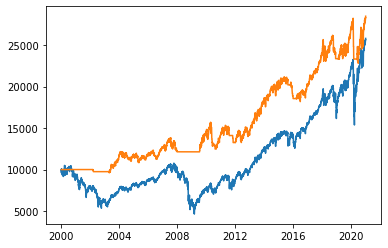

In [21]:
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal)

plt.show()